## Bayesian parameter estimation using MCMC

Authors: Audrey Olivier and Dimitris Giovanis <br>
Last modified on 12/14/2018 by Audrey Olivier

In Bayesian parameter estimation, one is looking to estimate the posterior pdf of the parameter vector characterizing the model, based on available data. The posterior pdf is given by Bayes' theorem:

$$ p(\theta \vert data) = \frac{p(data \vert \theta) p(\theta)}{p(data)} $$

The posterior pdf of nonlinear non-Gaussian models is often intractable, approximations must be used. In particular, Markov Chain Monte Carlo methods are a very popular way to sample from the posterior pdf. This notebook illustrates how to perfrom Bayesian parameter estimation via MCMC in UQpy, using the BayesParameterEstimation class. At the end of this notebook, we also show how to quickly check your results using some simple Diagnostics tools implemented in UQpy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots

In [2]:
# Function to plot posterior pdf from samples
def pdf_from_kde(domain, samples1d):
    bandwidth = 1.06 * np.std(samples1d) * samples1d.size ** (-1/5)
    kde = KernelDensity(bandwidth=bandwidth).fit(samples1d.reshape((-1,1)))
    log_dens = kde.score_samples(domain)
    return np.exp(log_dens)

## Probability model

In the following we learn the mean and covariance of a univariate gaussian distribution from data.

First, for the sake of this example, we generate fake data from a gaussian distribution with mean 10 and standard deviation 1.

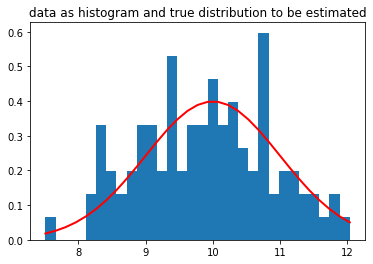

In [3]:
np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data_1 = np.random.normal(mu, sigma, 100).reshape((-1, 1))
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data_1, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In a Bayesian setting, the definition of a prior pdf is a key point. The prior for the parameters must be defined in the model. Note that if no prior is given, an inproper, uninformative, prior is chosen, $p(\theta)=1$ for all $\theta$.

In [4]:
from UQpy.Distributions import JointInd, Uniform, Lognormal
p0 = Uniform(loc=0., scale=15)
p1 = Lognormal(s=1., loc=0., scale=1.)
prior = JointInd(marginals=[p0, p1])

In [5]:
# create an instance of class Model
candidate_model = InferenceModel(dist_object=Normal(loc=None, scale=None), nparams=2, prior=prior)

In [6]:
# Learn the unknown parameters using MCMC
from UQpy.SampleMethods import MH
bayes_estimator = BayesParameterEstimation(data=data_1, inference_model=candidate_model, sampling_class=MH, 
                                           nsamples=500, jump=10, nburn=10, seed=np.array([1.0, 0.2]))

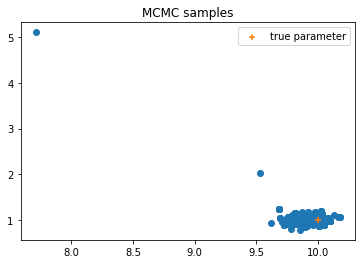

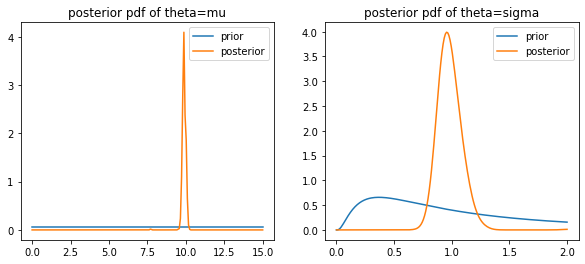

In [7]:
# print results
s = bayes_estimator.sampler.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(10, 1, marker = '+', label='true parameter')
plt.title('MCMC samples')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10, 4))

domain = np.linspace(0, 15, 200)[:, np.newaxis]
pdf = pdf_from_kde(domain, s[:, 0])
ax[0].plot(domain, p0.pdf(domain), label='prior')
ax[0].plot(domain, pdf, label='posterior')
ax[0].set_title('posterior pdf of theta=mu')
ax[0].legend()

domain = np.linspace(0, 2, 200)[:, np.newaxis]
pdf = pdf_from_kde(domain, s[:, 1])
ax[1].plot(domain, p1.pdf(domain), label='prior')
ax[1].plot(domain, pdf, label='posterior')
ax[1].set_title('posterior pdf of theta=sigma')
ax[1].legend()

plt.show()

## Regression model

Here a model is defined that is of the form 

$$y=f(\theta) + \epsilon$$

where f consists in running RunModel. In particular, here $f(\theta)=\theta_{0} x + \theta_{1} x^{2}$ is a regression model.

First we generate synthetic data, and add some noise to it.

In [8]:
# Generate data
from UQpy.Distributions import Normal
from UQpy.RunModel import RunModel

param_true = np.array([1.0, 2.0]).reshape((1, -1))
print('Shape of true parameter vector: {}'.format(param_true.shape))

h_func = RunModel(model_script='pfn_models.py', model_object_name='model_quadratic', vec=False, 
                  var_names=['theta_0', 'theta_1'])
h_func.run(samples=param_true)
data_clean = np.array(h_func.qoi_list[0])

Shape of true parameter vector: (1, 2)


In [9]:
# Add noise, use a RandomState for reproducible results
error_covariance = 1.
noise = Normal(loc=0., scale=np.sqrt(error_covariance)).rvs(nsamples=50, random_state=123).reshape((50, ))
data_3 = data_clean + noise
print('Shape of data: {}'.format(data_3.shape))
print(data_3[:4])

Shape of data: (50,)
[-1.0856306   1.2847257   1.02433627 -0.14436219]


In [10]:
from UQpy.Distributions import Normal, JointInd
p0 = Normal()
p1 = Normal()
prior = JointInd(marginals=[p0, p1])

inference_model = InferenceModel(nparams=2, runmodel_object=h_func, error_covariance=error_covariance,
                                 prior=prior)

In [11]:
from UQpy.SampleMethods import MH

proposal = JointInd([Normal(scale=0.1), Normal(scale=0.05)])

bayes_estimator = BayesParameterEstimation(
    data=data_3, inference_model=inference_model, sampling_class=MH, nsamples=500, jump=10, nburn=0, 
    proposal=proposal, seed=[0.5, 2.5], verbose=True, random_state=456)


UQpy: Initialization of MH algorithm complete.
UQpy: Running MCMC...
UQpy: MCMC run successfully !
UQpy: Parameter estimation with MH completed successfully!


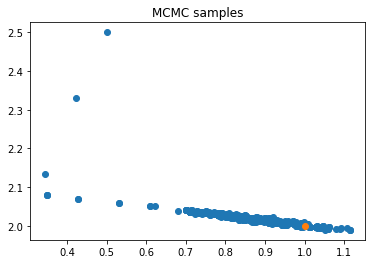

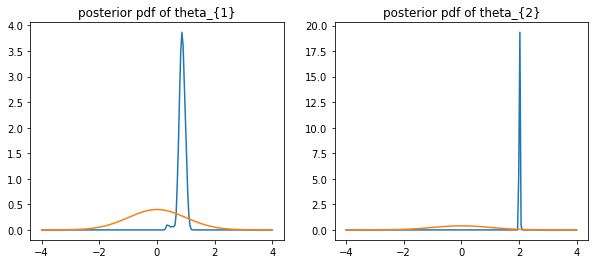

[[0.5        2.5       ]
 [0.42183819 2.33082211]
 [0.34546832 2.13295156]
 [0.34862315 2.07992359]]


In [12]:
s = bayes_estimator.sampler.samples
plt.scatter(s[:,0], s[:,1])
plt.scatter(1.0, 2.0, label='true value')
plt.title('MCMC samples')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,4))

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
pdf_ = pdf_from_kde(domain, s[:, 0])
ax[0].plot(domain, pdf_, label='posterior')
ax[0].plot(domain, p0.pdf(domain), label='prior')
ax[0].set_title('posterior pdf of theta_{1}')

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
pdf_ = pdf_from_kde(domain, s[:, 1])
ax[1].plot(domain, pdf_, label='posterior')
ax[1].plot(domain, p1.pdf(domain), label='prior')
ax[1].set_title('posterior pdf of theta_{2}')

plt.show()

print(bayes_estimator.sampler.samples[:4])